In [109]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, and_, or_

In [4]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Precipitation Analysis

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# NOTE: there is no data on 2018 year so let takes the max date and count a year back from that
max_date_s = session.query(func.max(Measurement.date)).one()[0]
max_date = datetime.strptime(max_date_s, '%Y-%m-%d')
print(f'Max date is {max_date:%Y-%m-%d}')
year_ago_from_max_date = max_date - timedelta(365)
print(f'Year ago from {max_date:%Y-%m-%d} it was {year_ago_from_max_date:%Y-%m-%d}')
year_ago_from_max_date_s = datetime.strftime(year_ago_from_max_date, '%Y-%m-%d')
raw_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago_from_max_date_s).all()

Max date is 2017-08-23
Year ago from 2017-08-23 it was 2016-08-23


In [10]:
data = pd.DataFrame(raw_data, columns=['Date', 'Precipitation'])
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data = data.set_index('Date', drop=True).dropna(how='any')
data.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


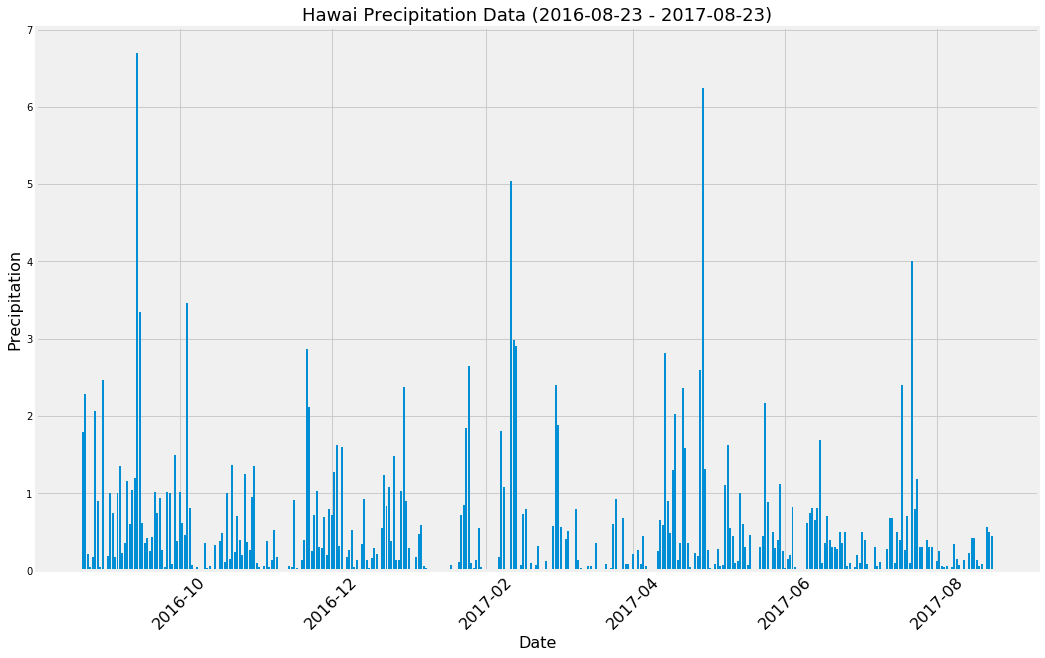

In [14]:
plt.figure(figsize=(16,10))
plt.bar(data.index, data['Precipitation'])
plt.xticks(fontsize=16, rotation=45)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Precipitation', fontsize=16)
plt.title(f'Hawai Precipitation Data ({year_ago_from_max_date_s} - {max_date_s})', fontsize=18)
plt.savefig('Images/HawaiPrecipitation.png')
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [13]:
# How many stations are available in this dataset?
number_of_stations = session.query(Station).count()
print(f'There are {number_of_stations} stations')

There are 9 stations


In [17]:
# What are the most active stations?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = most_active_stations[0][0]
station_agg_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)) \
    .filter_by(station=most_active_station) \
    .all()
station_agg_data

[(54.0, 85.0, 71.66378066378067)]

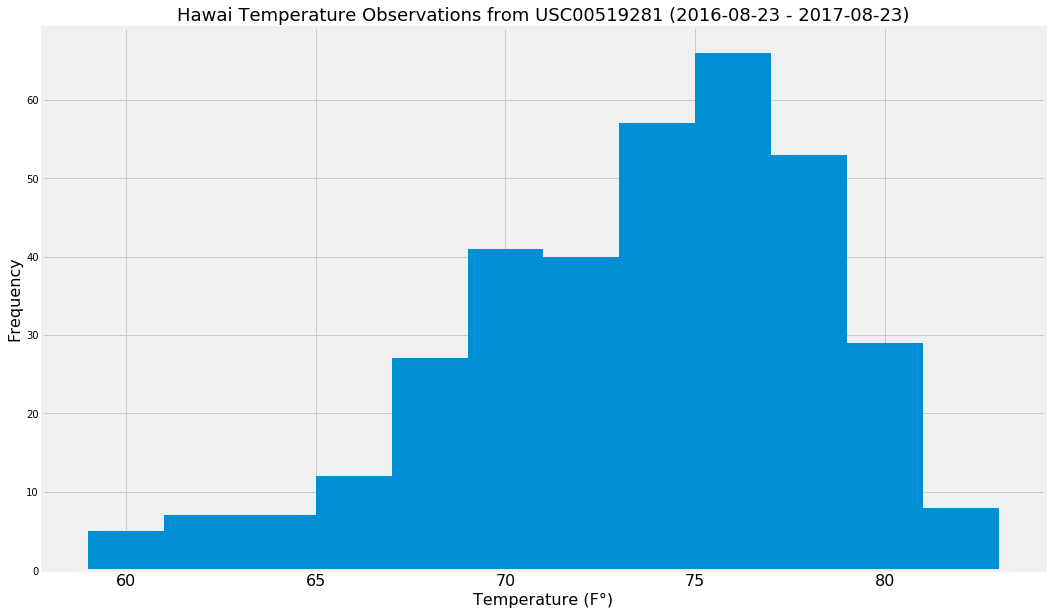

In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_temp = session.query(Measurement.tobs).filter_by(station=most_active_station) \
    .filter(and_(Measurement.date >= year_ago_from_max_date_s, Measurement.date <= max_date_s)).all()
last_year_temp = [temp[0] for temp in last_year_temp]
plt.figure(figsize=(16,10))
plt.hist(last_year_temp, bins=12)
plt.xticks(fontsize=16)
plt.xlabel('Temperature (F°)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title(f'Hawai Temperature Observations from {most_active_station} ({year_ago_from_max_date_s} - {max_date_s})', fontsize=18)
plt.savefig('Images/TemperatureHistogram.png')
plt.show()

In [28]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).first()

(62.0, 69.57142857142857, 74.0)


In [121]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = datetime.strftime(datetime.now() - timedelta(365 * 2) - timedelta(30), '%Y-%m-%d')
end_date = datetime.strftime(datetime.now() - timedelta(365 * 2) - timedelta(20), '%Y-%m-%d')
trip_t_min, trip_t_avg, trip_t_max = calc_temps(start_date, end_date)
print(f'Trip starts on {start_date} and ends on {end_date}')
print(f'Min temp: {trip_t_min}. Max temp: {trip_t_max}. Avg. temp: {trip_t_avg}')

Trip starts on 2016-09-08 and ends on 2016-09-18
Min temp: 71.0. Max temp: 83.0. Avg. temp: 77.55072463768116


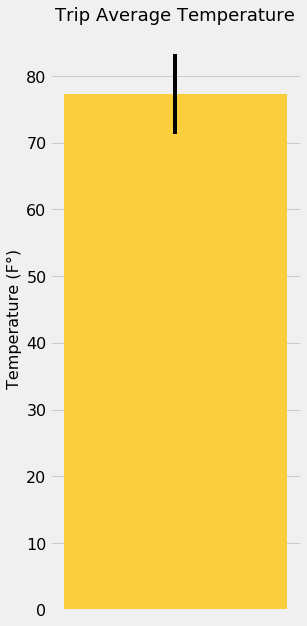

In [136]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(4,10))
plt.bar([0], trip_temp[1], yerr=[(trip_t_max - trip_t_min) / 2], color='#FACE3D')
plt.xticks([],fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(-0.45, 0.45)
plt.ylabel('Temperature (F°)', fontsize=16)
plt.title(f'Trip Average Temperature', fontsize=18)
plt.savefig('Images/TripAverageTemperature.png')
plt.show()

In [123]:
# Calculate the rainfall per weather station using the previous year's matching dates.
sub_query = session.query(Measurement.station, func.sum(Measurement.prcp).label('total'))\
    .filter(Measurement.date >= start_date)\
    .filter(Measurement.date <= end_date)\
    .group_by(Measurement.station)\
    .subquery()
rainfall_per_station = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, sub_query.c.total) \
    .join(sub_query, Station.station == sub_query.c.station) \
    .all()
rainfall_per_station

[('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  1.9500000000000002),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  1.9000000000000001),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  2.5999999999999996),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  2.5199999999999996),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  4.92),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  15.809999999999999)]

## Optional Challenge Assignment

In [124]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [125]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
start_date_this_year = datetime.strptime(start_date, '%Y-%m-%d') + timedelta(2 * 365)
end_date_this_year = datetime.strptime(end_date, '%Y-%m-%d') + timedelta(2 * 365)
current_date = start_date_this_year
dates = []
normals = []
while current_date < end_date_this_year:
    normal = daily_normals(datetime.strftime(current_date, '%m-%d'))
    normals.append(normal[0])
    dates.append(current_date)
    current_date += timedelta(1)
normals

[(66.0, 76.22222222222223, 83.0),
 (68.0, 76.36538461538461, 84.0),
 (67.0, 76.61224489795919, 85.0),
 (70.0, 76.69565217391305, 83.0),
 (68.0, 75.89795918367346, 85.0),
 (68.0, 75.875, 82.0),
 (69.0, 75.98076923076923, 85.0),
 (67.0, 76.14, 81.0),
 (70.0, 77.40384615384616, 86.0),
 (68.0, 76.57692307692308, 83.0)]

In [127]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_date = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'], index=dates)
trip_date

,tmin,tavg,tmax
2018-09-08,66.0,76.222222,83.0
2018-09-09,68.0,76.365385,84.0
2018-09-10,67.0,76.612245,85.0
2018-09-11,70.0,76.695652,83.0
2018-09-12,68.0,75.897959,85.0
2018-09-13,68.0,75.875000,82.0
2018-09-14,69.0,75.980769,85.0
2018-09-15,67.0,76.140000,81.0
2018-09-16,70.0,77.403846,86.0
2018-09-17,68.0,76.576923,83.0


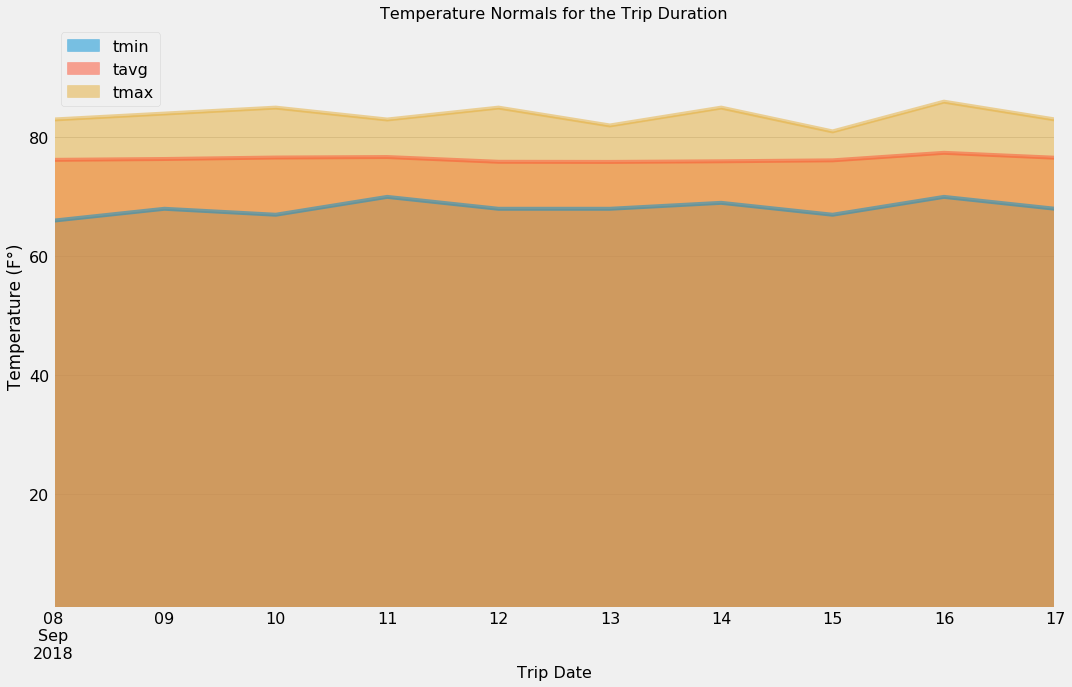

In [133]:
# Plot the daily normals as an area plot with `stacked=False`
ax = trip_date.plot(kind='area', stacked=False, figsize=(16,10), fontsize=16)
ax.set_xlabel('Trip Date', fontsize=16)
ax.set_ylabel('Temperature (F°)')
ax.set_title('Temperature Normals for the Trip Duration', fontsize=16)
x_ticks = ax.get_xticks()
ax.set_xlim(x_ticks[0] + 1, x_ticks[1])
ax.set_ylim(1, 99)
ax.legend(fontsize=16)